# house sales

---

### Intro / Введение

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

It contains 19 house features plus the price and the id columns, along with 21613 observations.
It's a great dataset for evaluating simple regression models.

---

### Features / Признаки

**date** дата продажи

**bedrooms** кол-во спален

**bathrooms** кол-во санузлов (дробное?)

**sqft_living** жилая площадь, кв. фут

**sqft_lot** общая площадь, кв. фут

**floors** кол-во этажей

**waterfront** набережная, 0 или 1

**view** вид, оценка от 1 до 5, 0 - без вида или незаполнено

**condition** состояние, оценка от 1 до 5

**grade** класс, оценка от 1 до 13

**sqft_above** площадь над землей, кв. фут

**sqft_basement** площадь под землей, кв. фут

**yr_built** год постройки

**yr_renovated** год ремонта, 0 - без ремонта или незаполнено

**zipcode** почтовый индекс

**lat** широта

**long** долгота

**sqft_living15** жилая площадь, кв. фут

**sqft_lot15** общая площадь, кв. фут

**price (target)** цена $

---

### Task / Задача
отработать навыки работы с признаками

In [114]:
#@title ### Import / Загрузка
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

try:
  import pytolemaic
except ImportError:
  %pip install pytolemaic
  import pytolemaic

try:
  import featuretools as ft
except ModuleNotFoundError:
  %pip install featuretools
  import featuretools as ft

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import compress
from scipy import stats
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

sns.set_theme(style="whitegrid")

X, y = fetch_openml(data_id=42092, return_X_y=True, as_frame=True)
data = X
data['price'] = y

### Exploratory Data Analysis / Исследующий анализ данных

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           21613 non-null  object  
 1   bedrooms       21613 non-null  float64 
 2   bathrooms      21613 non-null  float64 
 3   sqft_living    21613 non-null  float64 
 4   sqft_lot       21613 non-null  float64 
 5   floors         21613 non-null  float64 
 6   waterfront     21613 non-null  float64 
 7   view           21613 non-null  float64 
 8   condition      21613 non-null  float64 
 9   grade          21613 non-null  float64 
 10  sqft_above     21613 non-null  float64 
 11  sqft_basement  21613 non-null  float64 
 12  yr_built       21613 non-null  float64 
 13  yr_renovated   21613 non-null  float64 
 14  zipcode        21613 non-null  category
 15  lat            21613 non-null  float64 
 16  long           21613 non-null  float64 
 17  sqft_living15  21613 non-null  

In [180]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,20141013T000000,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178,47.5112,-122.257,1340.0,5650.0,221900.0
1,20141209T000000,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125,47.7210,-122.319,1690.0,7639.0,538000.0
2,20150225T000000,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028,47.7379,-122.233,2720.0,8062.0,180000.0
3,20141209T000000,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136,47.5208,-122.393,1360.0,5000.0,604000.0
4,20150218T000000,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074,47.6168,-122.045,1800.0,7503.0,510000.0


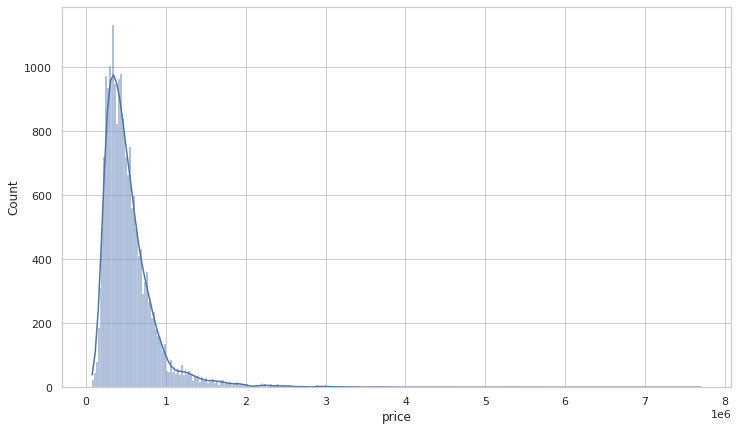

In [181]:
#@title #### Observation of target variable / Наблюдение целевого признака
fig, ax = plt.subplots(figsize=(12, 7))
sns.histplot(data['price'], kde=True, ax=ax);

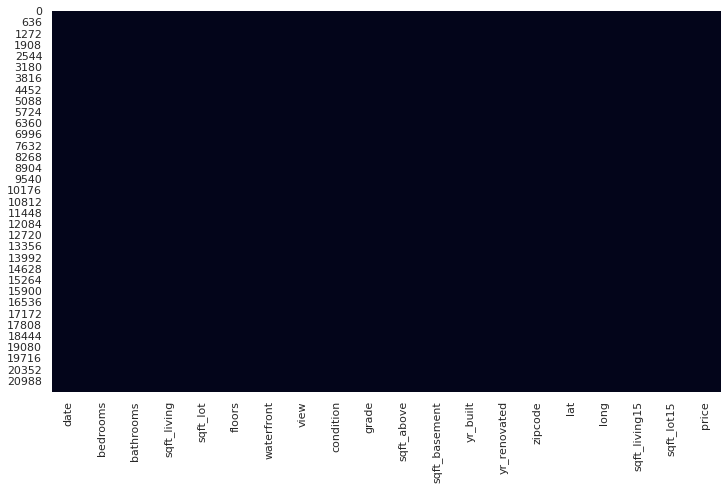

In [182]:
#@title #### Missing values / Пропущенные значения

#@markdown нет пропущенных значений

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(data.isnull(), cbar=False, ax=ax);

In [115]:
def get_outliers(col, mode='z'):
  if mode == 'iqr':
    q1 = col.quantile(0.02)
    q3 = col.quantile(0.98)
    iqr = q3 - q1
    idx = (col < (q1-1.5*iqr)) | (col > (q3+1.5*iqr))
    idx = idx[idx == True].index
  else:
    idx = stats.zscore(col) > 7
    idx = np.where(idx)[0]
  return idx

#### Categorical features / Категориальные признаки

In [184]:
data['zipcode'].head()

0    98178
1    98125
2    98028
3    98136
4    98074
Name: zipcode, dtype: category
Categories (70, object): ['98001', '98002', '98003', '98004', ..., '98178', '98188', '98198', '98199']

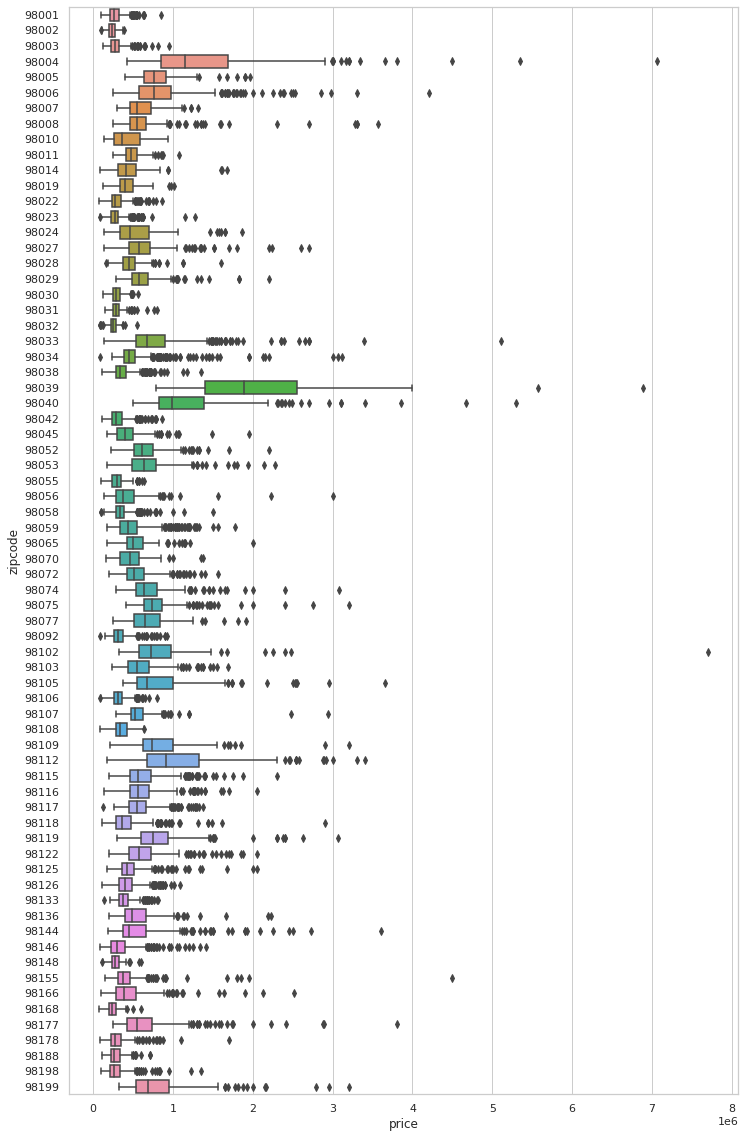

In [185]:
fig, ax = plt.subplots(figsize=(12, 20))
sns.boxplot(y='zipcode', x='price', data=data, orient='h', ax=ax);

In [116]:
encoder = OrdinalEncoder(dtype='int16')
data[['zipcode']] = encoder.fit_transform(data[['zipcode']])

#### Numerical features / Числовые признаки

In [117]:
int_cols = ['bedrooms', 'sqft_living', 'sqft_lot',
            'waterfront', 'view', 'condition',
            'grade', 'sqft_above', 'sqft_basement',
            'yr_built', 'yr_renovated', 'sqft_living15',
            'sqft_lot15', 'price']
data[int_cols] = data[int_cols].astype('int')

In [188]:
data.drop(columns=['zipcode']).head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,221900
1,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,538000
2,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,180000
3,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,604000
4,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,510000


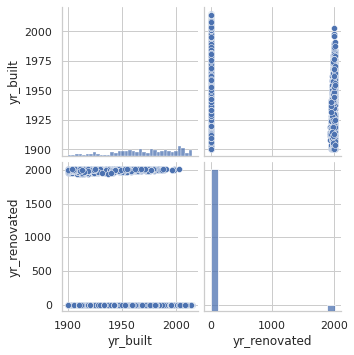

In [189]:
sns.pairplot(data[['date', 'yr_built', 'yr_renovated']]);

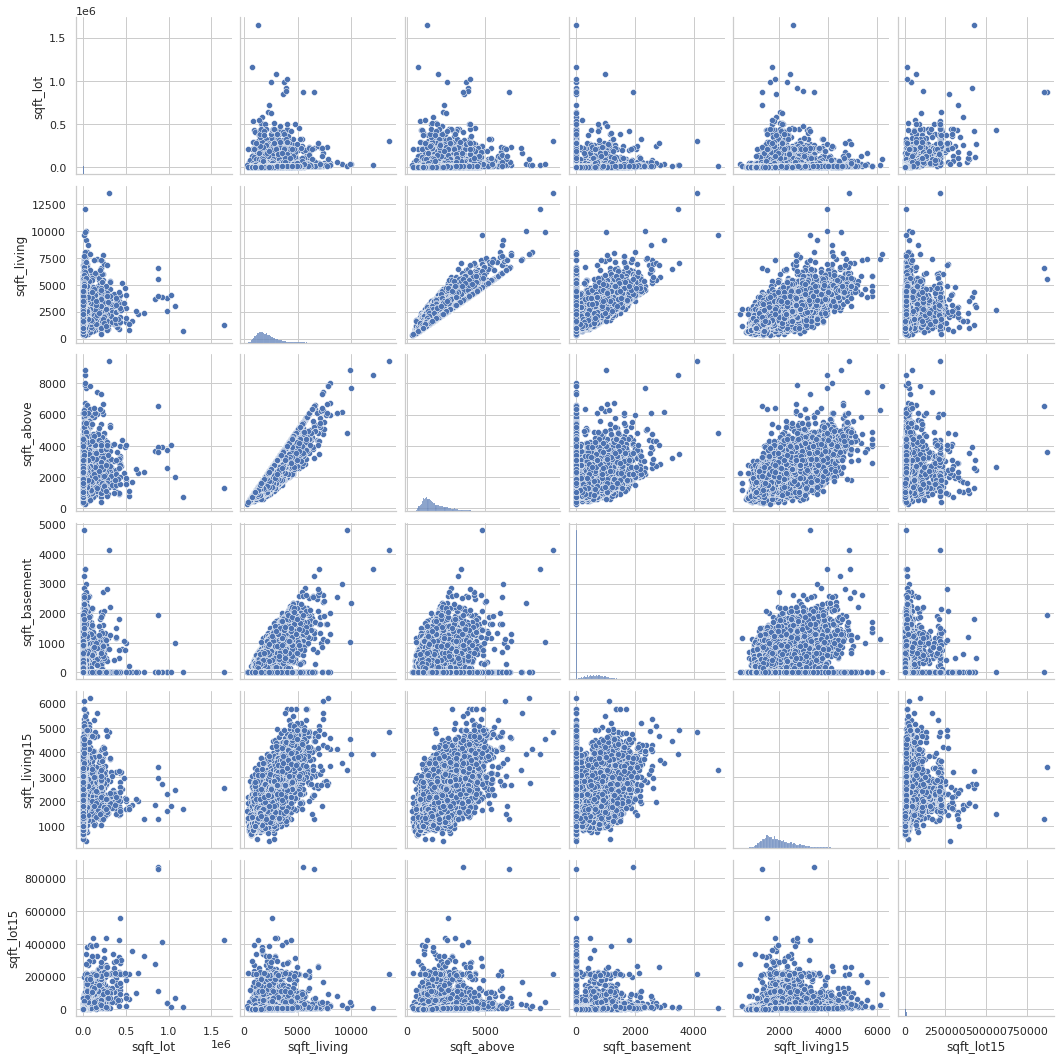

In [190]:
sns.pairplot(data[['sqft_lot', 'sqft_living', 'sqft_above',
                    'sqft_basement', 'sqft_living15', 'sqft_lot15']]);

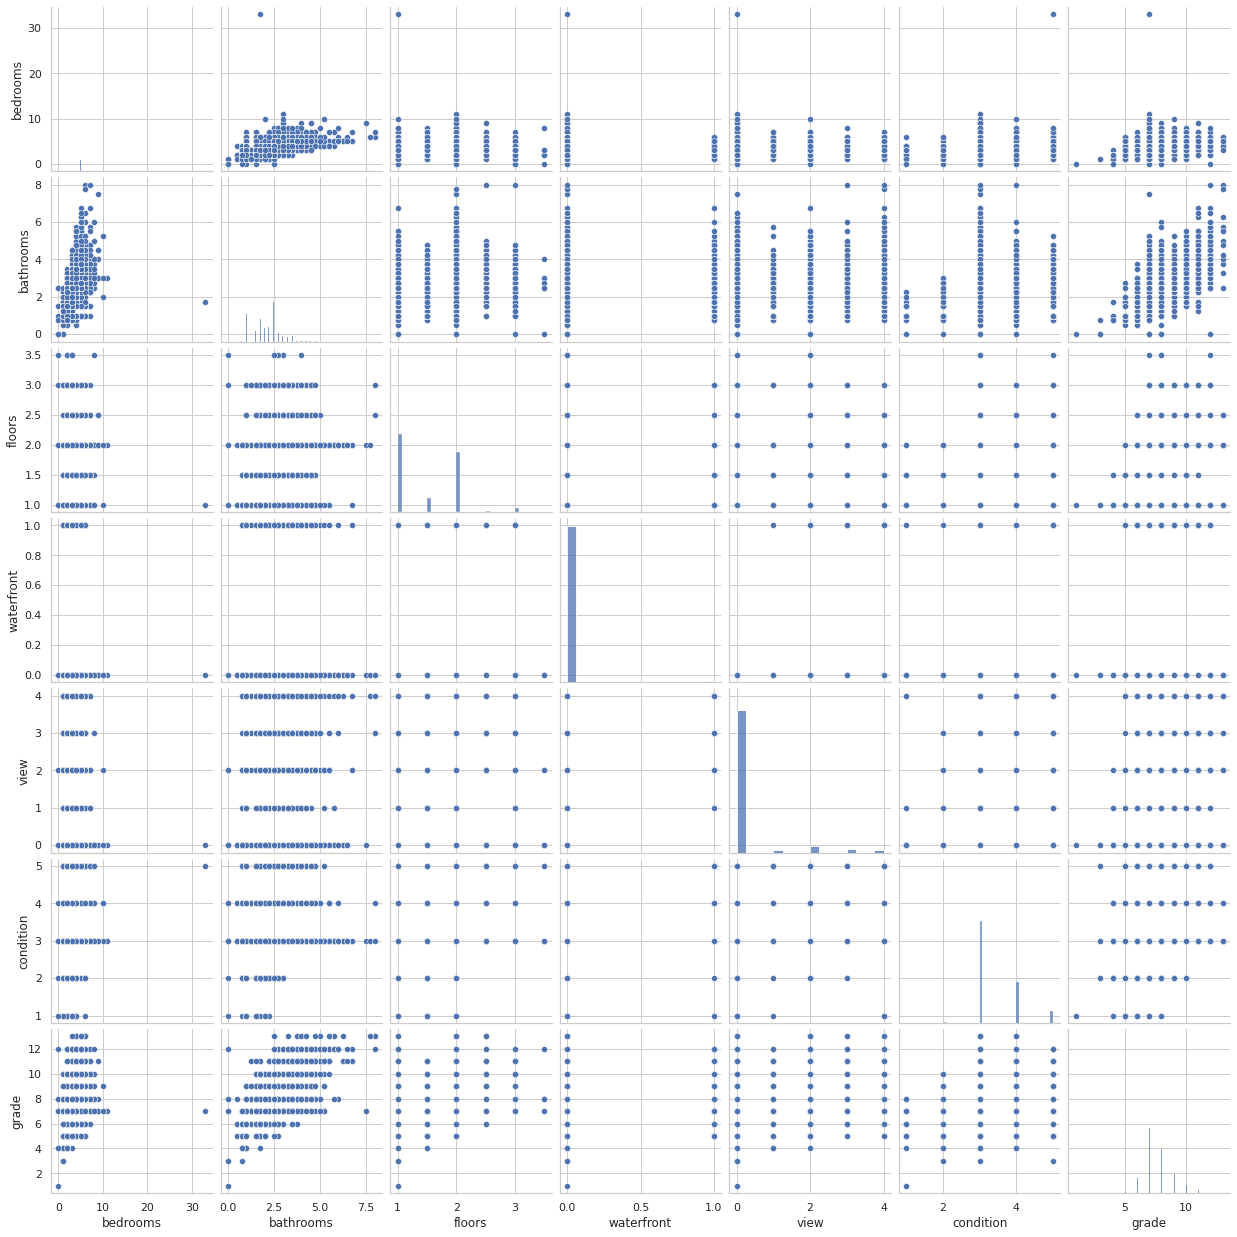

In [191]:
sns.pairplot(data[['bedrooms', 'bathrooms', 'floors', 'waterfront',
                      'view', 'condition', 'grade']]);

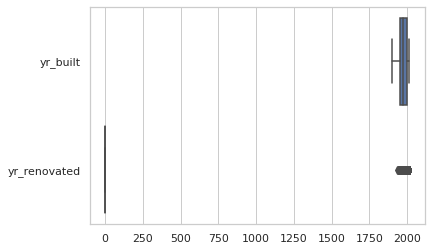

In [192]:
sns.boxplot(data=data[['date', 'yr_built', 'yr_renovated']], orient='h');

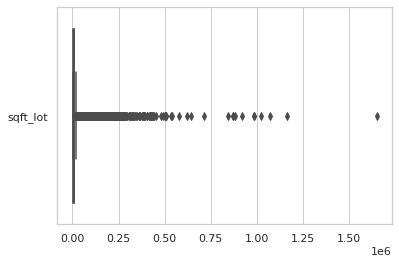

In [193]:
sns.boxplot(data=data[['sqft_lot']], orient='h');

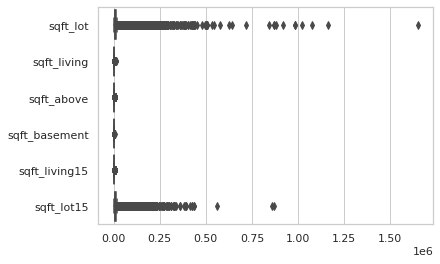

In [194]:
sns.boxplot(data=data[['sqft_lot', 'sqft_living', 'sqft_above',
                    'sqft_basement', 'sqft_living15', 'sqft_lot15']], orient='h');

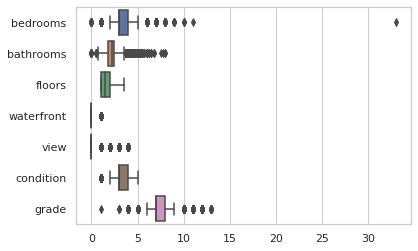

In [195]:
sns.boxplot(data=data[['bedrooms', 'bathrooms', 'floors', 'waterfront',
                      'view', 'condition', 'grade']], orient='h');

In [118]:
cols_w_outliers = ['bedrooms', 'bathrooms', 'sqft_living',
                   'sqft_lot', 'sqft_basement', 'price']

for col in cols_w_outliers:
  data.drop(index=get_outliers(data[col]), inplace=True, errors='ignore')

#### Correlation to the target / Корреляция к целевому признаку

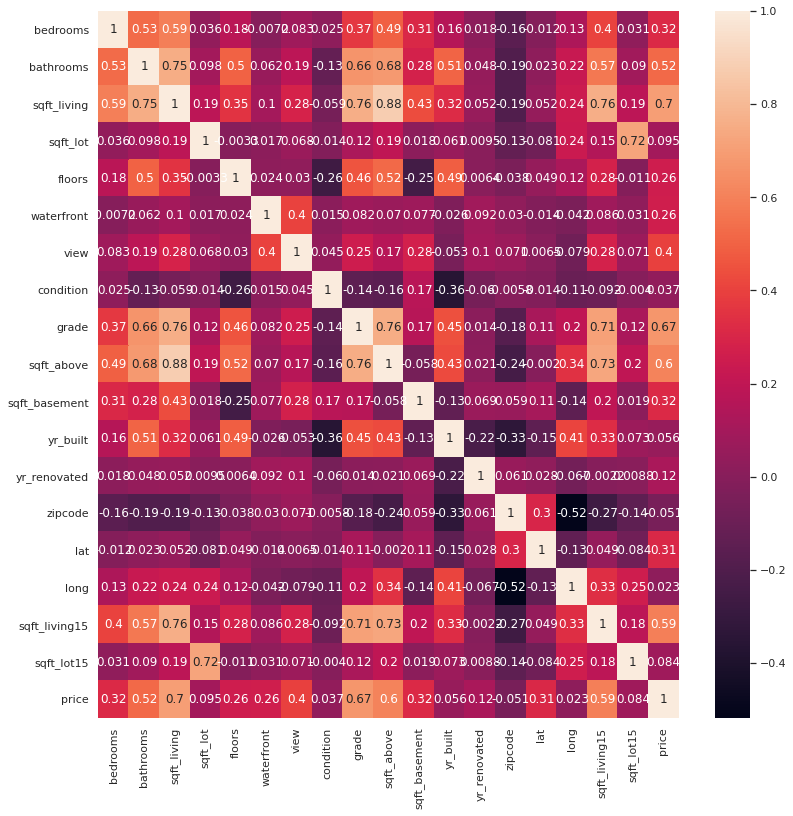

In [197]:
fig, ax = plt.subplots(figsize=(13, 13))
corr = data.corr()
sns.heatmap(corr, annot=True, ax=ax);

In [198]:
corr_target = abs(corr['price'])
weak_cols = corr_target[corr_target < 0.1]
print(weak_cols)

sqft_lot      0.094664
condition     0.037365
yr_built      0.056243
zipcode       0.050593
long          0.022697
sqft_lot15    0.084219
Name: price, dtype: float64


In [119]:
weak_cols = ['sqft_lot']
data.drop(columns=weak_cols, inplace=True)

In [8]:
def get_corr(df, threshold=0.8):
  corr_matrix = df.corr()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  to_drop = [col for col in upper.columns if any(abs(upper[col]) >= threshold)]
  return to_drop

### Data Wrangling and Transformation / Первичная обработка данных

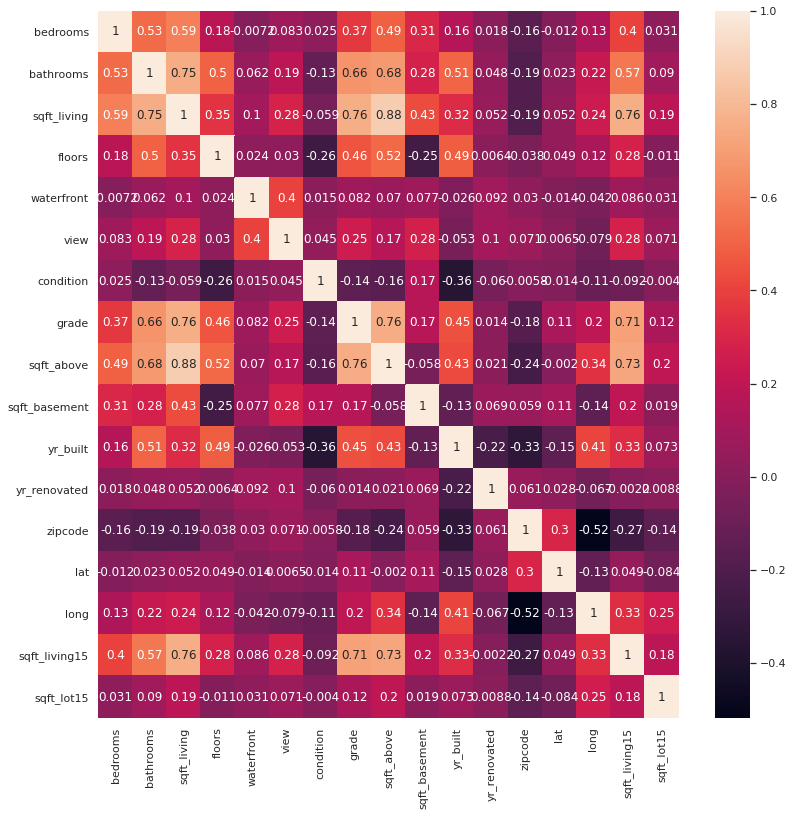

In [202]:
#@title #### Multicollinearity / Мультиколинеарность
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(data.drop(columns=['price']).corr(), annot=True, ax=ax);

sqft_living15 и sqft_lot15 дублируют sqft_living и sqft_lot, а так же grade и sqft_above коррелируют с sqft_living. то есть можно отбросить первые два признака, а так же sqft_above, который можно получить как sqft_living - sqft_basement

In [120]:
data.drop(columns=['sqft_living15', 'sqft_lot15', 'sqft_above'], inplace=True)

In [276]:
y = data['price']
X = data.drop(columns=['price'])

In [277]:
#@title #### Feature Engineering / Конструирование признаков

X['date'] = pd.to_datetime(X['date'].str[:8], yearfirst=True)
#X['latlong'] = X[['lat', 'long']].apply(tuple, axis=1)

es = ft.EntitySet(id='house sales')
es.entity_from_dataframe(entity_id='data', dataframe=X, 
                         index='index', 
                         variable_types={'date': ft.variable_types.Datetime,
                         'zipcode': ft.variable_types.Ordinal,
                         #'latlong': ft.variable_types.LatLong
                         })

trans = ['year',
         'add_numeric',
         'multiply_numeric',
         #'haversine',
]

feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'data',
                                      trans_primitives = trans)
X['date'] = X['date'].dt.year.astype('int16')

/usr/local/lib/python3.7/dist-packages/featuretools/entityset/entity.py:463: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


In [278]:
feature_matrix.drop(columns=get_corr(feature_matrix), inplace=True)

In [279]:
#@title ####Recursive feature selection / Рекурсивный отбор признаков
eliminated = ['sqft_basement * view', 'condition', 'condition + floors']
eliminated += ['sqft_basement * waterfront', 'sqft_basement * yr_renovated', 'view * yr_renovated', 'waterfront * yr_renovated']
eliminated += ['view', 'sqft_basement', 'sqft_basement + yr_renovated']
eliminated += ['yr_renovated', 'waterfront']
eliminated += ['bedrooms', 'bedrooms + view']
eliminated += ['floors', 'YEAR(date)']
feature_matrix.drop(columns=eliminated, inplace=True)

In [280]:
X = feature_matrix

In [281]:
#@title #### Scaling / Масштабирование
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [192]:
#@title #### Variance / Дисперсия
var = VarianceThreshold(threshold=0.3)
var = var.fit(X_sc, y)
lo_var = list(compress(X.columns, ~var.get_support()))

if len(lo_var):
  print('columns with low variance:', lo_var)

In [282]:
#@title #### Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(
        X_sc, y, test_size=0.2, random_state=42)

### Machine Learning / Машинное обучение

In [283]:
#@title #### Baseline / Базовая модель
baseline = LinearRegression(n_jobs=-1).fit(X_train, y_train)
baseline.score(X_test, y_test)

0.6889975483046377

In [ ]:
#@title #### Parameter tuning / Настройка гиперпараметров
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=ExtraTreesRegressor(
    min_samples_split=7, max_features=X.shape[1], n_jobs=-1),
    param_grid={
        'n_estimators': range(50,126,25),
        #'max_features': range(1, X.shape[1]+1),
        #'min_samples_leaf': range(1,25,5),
        #'min_samples_split': range(1,15, 3),
    }, scoring='r2', cv=5, n_jobs=-1).fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

In [284]:
#@title #### Model / Модель
estimator = ExtraTreesRegressor(n_estimators=75, 
    min_samples_split=7, max_features=X.shape[1], 
    n_jobs=-1).fit(X_train, y_train)
estimator.score(X_test, y_test)

0.8647248124355063

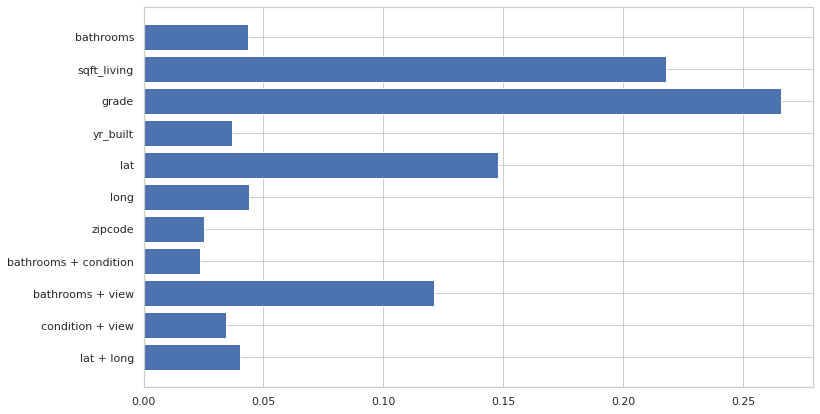

In [285]:
#@title #### Feature importance / Важность признаков
fig, ax = plt.subplots(figsize=(12, 7))
cols = X.columns
y_pos = np.arange(estimator.n_features_)

ax.barh(y_pos, estimator.feature_importances_)
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
plt.show()

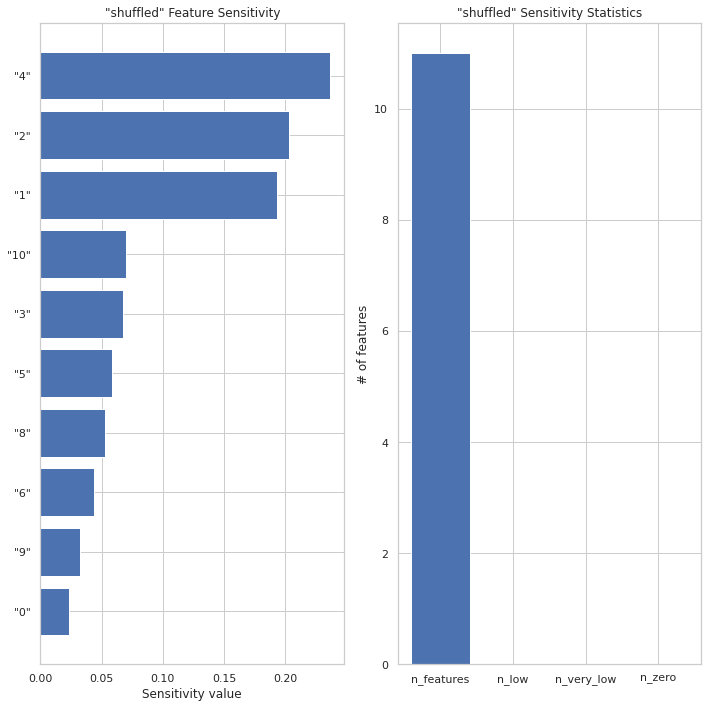

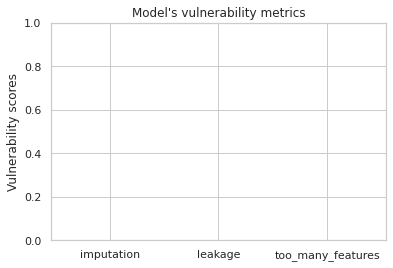

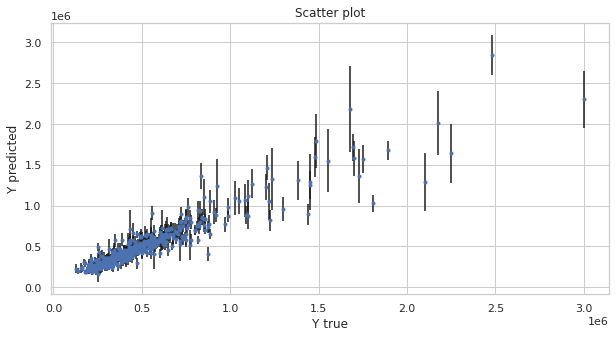

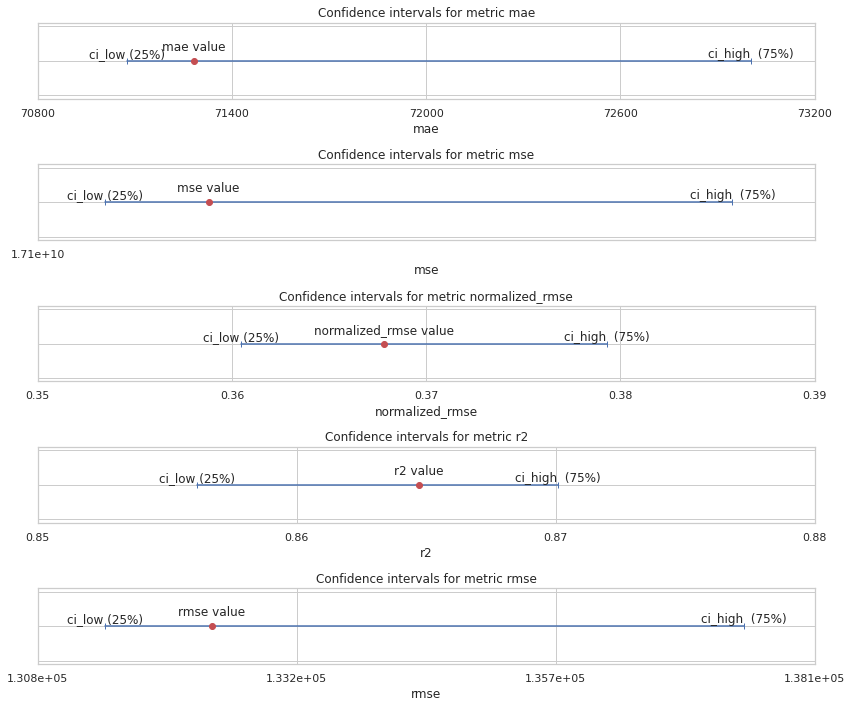

In [286]:
#@title #### Model evaluation / Оценка модели
from pytolemaic.pytrust import PyTrust
import pprint 

pp = pprint.PrettyPrinter(indent=4)
pytrust = PyTrust(model=estimator,
       xtrain=X_train, ytrain=y_train,
       xtest=X_test, ytest=y_test)

dataset_analysis_report = pytrust.dataset_analysis_report
sensitivity_report = pytrust.sensitivity_report
scoring_report = pytrust.scoring_report
quality_report = pytrust.quality_report

for report in [dataset_analysis_report, sensitivity_report, scoring_report, quality_report]:
    report.plot() # plot graphs
    #pp.pprint(report.to_dict(printable=True))
    #pp.pprint(report.to_dict_meaning())

#uncertainty_model = pytrust.create_uncertainty_model()
#create_lime_explainer = pytrust.create_lime_explainer()

In [287]:
#@title #### Insights
for line in pytrust.insights:
  print(line)

SensitivityOfFeaturesReport.shuffled: The most important feature is '4', followed by '2'and '1'.


In [288]:
#@title #### Shuffled column elimination
report = sensitivity_report.to_dict(printable=True)
sens = report['shuffle_report']['sensitivities']

try:
  del sens['...']
except KeyError:
  pass
sens = pd.Series(sens)
to_drop = list(X.columns[sens[sens < 0.015].index])
if len(to_drop):
  print(to_drop)